# Parallelization: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Parallelization 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- What is chat messages, chat model, binding tools? --> [Build a simple graph with nodes, normal edges, and conditional edges.](https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb)




---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [26]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse already exists
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [27]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [28]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [29]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [30]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
model_id = "us.amazon.nova-pro-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f964ebdc1c0>, model_id='us.amazon.nova-pro-v1:0', temperature=0.0, region_name='us-east-1', provider='amazon', supports_tool_choice_values=['auto'])

## 6. Grpah 정의 하기

### State 정의

In [31]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

### Node 및 분기  함수 정의

In [32]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']} shortly in Korean")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']} shortly in Korean")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']} shortly in Korean")
    return {"poem": msg.content}


In [33]:
def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

### 그래프 구조 만들기

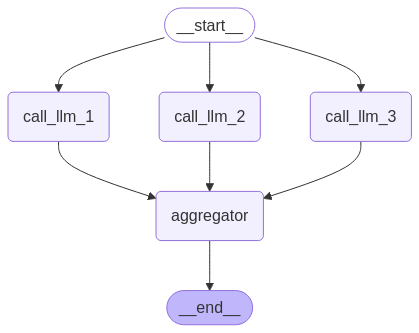

In [34]:
# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))



### Graph 호출

In [38]:
# Invoke
state = parallel_workflow.invoke({"topic": "고양이"},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [39]:
state

{'topic': '고양이',
 'joke': '물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:\n\n고양이가 컴퓨터 앞에 앉아서 말했죠: "야호! 나는 인터넷 고양이 블로거가 될거야!" 그런데 다음 순간, 고양이는 키보드를 발로 차며 말했죠: "얘야, 너 너무 복잡해! 나는 그냥 잠자는 게 더 좋아."\n\n웃음을 주시길 바랍니다!',
 'story': '어느 날, 작은 마을에 한 마리의 고양이가 살고 있었습니다. 이 고양이의 이름은 나비였습니다. 나비는 매우 호기심 많은 고양이였습니다. \n\n어느 날 아침, 나비는 마을을 산책하던 중 예쁜 꽃밭을 발견했습니다. 나비는 꽃밭으로 달려가 꽃들을 냄새 맡으며 행복해했습니다. 그때 갑자기 강한 바람이 불었고, 나비는 꽃잎 하나가 눈에 들어가 아파했습니다.\n\n나비는 서둘러 집으로 돌아갔고, 주인은 나비의 눈을 부드럽게 닦아주었습니다. 며칠 후, 나비의 눈은 다시 맑아졌고, 나비는 다시 마을을 산책하러 나갔습니다.\n\n이후로 나비는 더욱 조심스럽게 꽃밭을 즐기며, 주인과 함께 행복한 시간을 보냈습니다. 마을 사람들도 나비를 보며 미소 지었습니다.\n\n그리고 나비는 계속해서 호기심 많은 모험을 즐기며, 마을의 사랑스러운 고양이로 남았습니다.',
 'poem': '고양이, 작은 꿈의 조각,\n부드러운 발걸음, 조용한 걸음걸음.\n눈빛에 담긴 비밀, 귀에 흐르는 바람소리,\n작은 울림, 큰 세상을 품다.\n\n고양이, 따뜻한 햇살 속에서,\n푹 쉬는 시간, 행복한 순간.\n꼬리 흔들림, 마음의 춤,\n작은 생명, 큰 사랑을 나누다.\n\n고양이, 밤의 조용한 동반자,\n별빛 아래 걷는 발자국.\n꿈꾸는 눈망울, 속삭이는 숨결,\n작은 존재, 큰 위로를 주다.\n\n고양이, 영원한 우리의 친구,\n시간을 뛰어넘는 따뜻한 기억.\n고양이와 함께한 나날들,\n작은 행복, 큰 세상의 일부.',
 'combined_output': 'Here\'s a story, joke, and poem about 고양이!\n\nS

### State 값 흐름에 따라 출력

In [40]:
print(state["combined_output"])

Here's a story, joke, and poem about 고양이!

STORY:
어느 날, 작은 마을에 한 마리의 고양이가 살고 있었습니다. 이 고양이의 이름은 나비였습니다. 나비는 매우 호기심 많은 고양이였습니다. 

어느 날 아침, 나비는 마을을 산책하던 중 예쁜 꽃밭을 발견했습니다. 나비는 꽃밭으로 달려가 꽃들을 냄새 맡으며 행복해했습니다. 그때 갑자기 강한 바람이 불었고, 나비는 꽃잎 하나가 눈에 들어가 아파했습니다.

나비는 서둘러 집으로 돌아갔고, 주인은 나비의 눈을 부드럽게 닦아주었습니다. 며칠 후, 나비의 눈은 다시 맑아졌고, 나비는 다시 마을을 산책하러 나갔습니다.

이후로 나비는 더욱 조심스럽게 꽃밭을 즐기며, 주인과 함께 행복한 시간을 보냈습니다. 마을 사람들도 나비를 보며 미소 지었습니다.

그리고 나비는 계속해서 호기심 많은 모험을 즐기며, 마을의 사랑스러운 고양이로 남았습니다.

JOKE:
물론입니다! 여기 고양이에 관한 짧은 농담이 있습니다:

고양이가 컴퓨터 앞에 앉아서 말했죠: "야호! 나는 인터넷 고양이 블로거가 될거야!" 그런데 다음 순간, 고양이는 키보드를 발로 차며 말했죠: "얘야, 너 너무 복잡해! 나는 그냥 잠자는 게 더 좋아."

웃음을 주시길 바랍니다!

POEM:
고양이, 작은 꿈의 조각,
부드러운 발걸음, 조용한 걸음걸음.
눈빛에 담긴 비밀, 귀에 흐르는 바람소리,
작은 울림, 큰 세상을 품다.

고양이, 따뜻한 햇살 속에서,
푹 쉬는 시간, 행복한 순간.
꼬리 흔들림, 마음의 춤,
작은 생명, 큰 사랑을 나누다.

고양이, 밤의 조용한 동반자,
별빛 아래 걷는 발자국.
꿈꾸는 눈망울, 속삭이는 숨결,
작은 존재, 큰 위로를 주다.

고양이, 영원한 우리의 친구,
시간을 뛰어넘는 따뜻한 기억.
고양이와 함께한 나날들,
작은 행복, 큰 세상의 일부.


## 7. Langfuse Tracing Output
![parallel.png](img/parallel.png)